# Классификация фейковых отзывов Amazon: Введение в машинное обучение

## Цель проекта
Создаем простую модель машинного обучения для классификации фейковых отзывов Amazon. Проект рассчитан на опытных разработчиков, которые хорошо знают программирование, но не знакомы с ML.

## Что мы изучим:
- Основные концепции машинного обучения
- Обработка текстовых данных
- Векторизация текста (TF-IDF)
- Логистическая регрессия
- Метрики оценки моделей
- Интерпретация результатов

## 1. Импорт библиотек и загрузка данных

Начнем с импорта необходимых библиотек. В мире ML используются специализированные инструменты:

In [3]:
# Основные библиотеки для работы с данными
import pandas as pd  # Как Excel, но в коде - для работы с таблицами
import numpy as np   # Математические операции над массивами

# Библиотеки для машинного обучения
from sklearn.model_selection import train_test_split  # Разделение данных
from sklearn.feature_extraction.text import TfidfVectorizer  # Преобразование текста в числа
from sklearn.linear_model import LogisticRegression  # Наша модель
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Метрики

# Для обработки текста
import re
import string

# Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка отображения
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Библиотеки успешно импортированы!")

Библиотеки успешно импортированы!


In [5]:
import kagglehub

import kaggle
# Download latest version
path = kagglehub.dataset_download("mexwell/fake-reviews-dataset")

print("Path to dataset files:", path)

c:\Users\igor\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 4.78M/4.78M [00:03<00:00, 1.48MB/s]

Extracting files...
Path to dataset files: C:\Users\igor\.cache\kagglehub\datasets\mexwell\fake-reviews-dataset\versions\1


### Загрузка данных

**Для разработчиков:** Данные в ML - это как база данных, но структурированная специально для обучения алгоритмов.

In [ ]:

# Загрузим данные (предполагаем, что файл уже скачан)
# Замените путь на актуальный путь к файлу с данными
try:
    # Попробуем загрузить данные
    df = pd.read_csv(path + '\\' +'fake reviews dataset.csv')
    print(f"Данные загружены успешно!")
    print(f"Размер датасета: {df.shape[0]} отзывов, {df.shape[1]} колонок")
except FileNotFoundError:
    print("Файл не найден. Создаем демо-данные для примера...")
    
    # Создаем синтетические данные для демонстрации
    np.random.seed(42)
    
    real_reviews = [
        "Great product, exactly as described. Fast shipping and good quality.",
        "Love this item! It works perfectly and the price is reasonable.",
        "Good value for money. The product is solid and well-made.",
        "Excellent customer service. The product arrived quickly and in perfect condition.",
        "This product exceeded my expectations. Highly recommend!",
        "Quality is good, but shipping took longer than expected.",
        "The product is okay, not amazing but does the job.",
        "Fair price for what you get. Product works as advertised."
    ]
    
    fake_reviews = [
        "Amazing! Best product ever! 5 stars! Buy now!",
        "Perfect! Incredible! Outstanding! Must have!",
        "Wow! Fantastic! Excellent! Great deal!",
        "Super! Awesome! Perfect! Highly recommended!",
        "Best purchase ever! Amazing quality! Perfect!",
        "Incredible product! Perfect! Five stars!",
        "Outstanding! Amazing! Perfect quality!",
        "Fantastic! Perfect! Best ever!"
    ]
    
    # Создаем DataFrame
    reviews = real_reviews * 50 + fake_reviews * 50  # Увеличиваем количество
    labels = [0] * (len(real_reviews) * 50) + [1] * (len(fake_reviews) * 50)  # 0 = real, 1 = fake
    
    df = pd.DataFrame({
        'text_': reviews,
        'label': labels,
        'rating': np.random.choice([1, 2, 3, 4, 5], len(reviews))
    })
    
    print(f"Демо-данные созданы: {df.shape[0]} отзывов")

Данные загружены успешно!
Размер датасета: 40432 отзывов, 4 колонок


## 2. Разведочный анализ данных (EDA)

**Аналогия для разработчиков:** Это как code review, но для данных - мы изучаем, что у нас есть, прежде чем начать работать.

In [9]:
# Базовая информация о данных
print("=== СТРУКТУРА ДАННЫХ ===")
print(f"Размер: {df.shape}")
print(f"Колонки: {list(df.columns)}")
print()

print("=== ПЕРВЫЕ 5 СТРОК ===")
display(df.head())
print()

print("=== ИНФОРМАЦИЯ О ТИПАХ ДАННЫХ ===")
print(df.info())
print()

print("=== ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ ===")
print(df.isnull().sum())

=== СТРУКТУРА ДАННЫХ ===
Размер: (40432, 4)
Колонки: ['category', 'rating', 'label', 'text_']

=== ПЕРВЫЕ 5 СТРОК ===


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfortable. I love it!Very pretty"
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I've had mine for a couple of years"
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and feel of this pillow.
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it is a great product for the price! I"
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the set for two months now and have not been



=== ИНФОРМАЦИЯ О ТИПАХ ДАННЫХ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB
None

=== ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ ===
category    0
rating      0
label       0
text_       0
dtype: int64


=== РАСПРЕДЕЛЕНИЕ КЛАССОВ ===
0 = Настоящие отзывы, 1 = Фейковые отзывы
label
CG    20216
OR    20216
Name: count, dtype: int64

=== ПРОЦЕНТНОЕ СООТНОШЕНИЕ ===
label
CG    50.0
OR    50.0
Name: proportion, dtype: float64


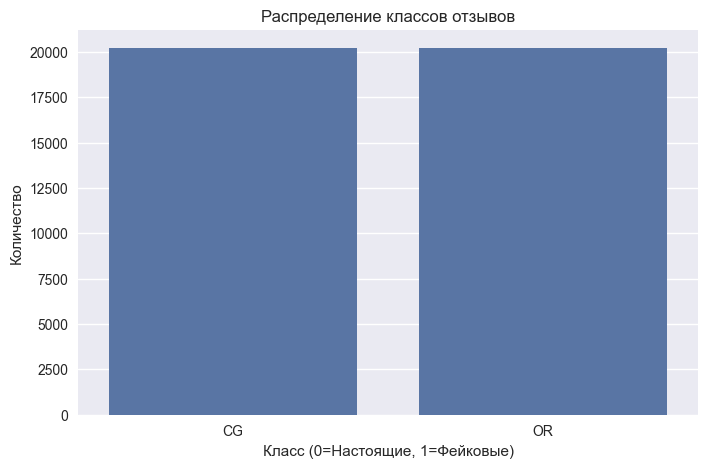

In [10]:
# Анализ целевой переменной (то, что мы пытаемся предсказать)
print("=== РАСПРЕДЕЛЕНИЕ КЛАССОВ ===")
print("0 = Настоящие отзывы, 1 = Фейковые отзывы")
print(df['label'].value_counts())
print()

# Процентное соотношение
print("=== ПРОЦЕНТНОЕ СООТНОШЕНИЕ ===")
print(df['label'].value_counts(normalize=True) * 100)

# Визуализация
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label')
plt.title('Распределение классов отзывов')
plt.xlabel('Класс (0=Настоящие, 1=Фейковые)')
plt.ylabel('Количество')
plt.show()

=== СТАТИСТИКА ДЛИНЫ ОТЗЫВОВ ===
      review_length                                                     \
              count        mean         std   min    25%    50%    75%   
label                                                                    
CG          20216.0  305.573506  307.037430  24.0   96.0  174.0  383.0   
OR          20216.0  396.970419  418.428047  28.0  121.0  224.0  498.0   

              word_count                                                      
          max      count       mean        std  min   25%   50%   75%    max  
label                                                                         
CG     1717.0    20216.0  61.288237  61.799015  1.0  19.0  35.0  77.0  318.0  
OR     2827.0    20216.0  73.642610  76.078420  5.0  23.0  42.0  93.0  373.0  


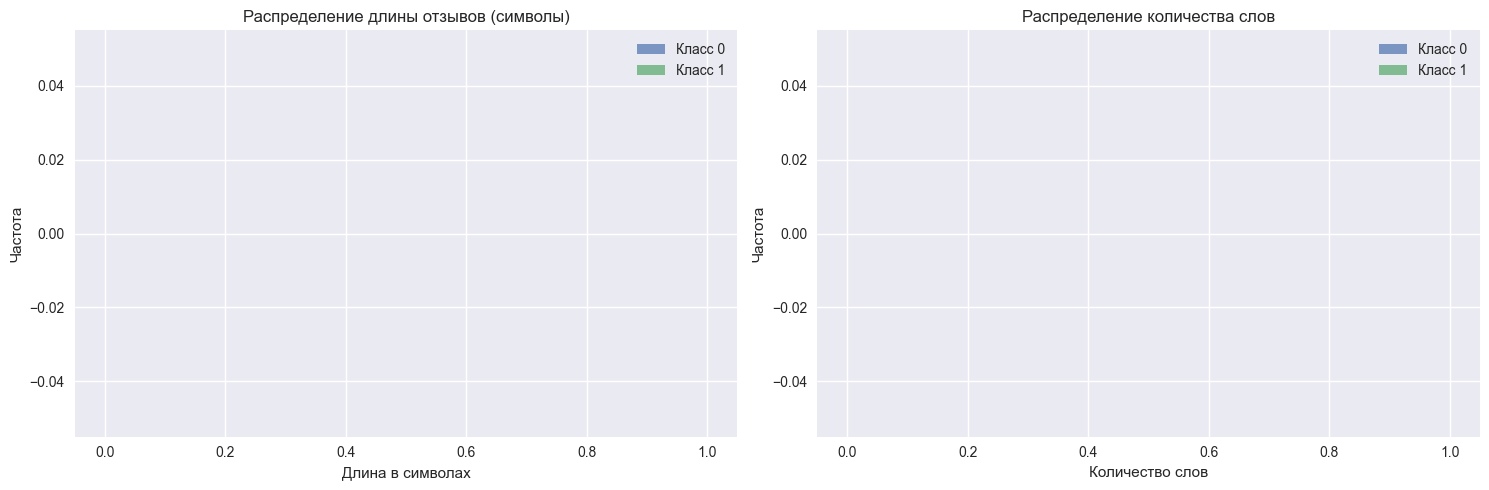

In [12]:
# Анализ длины отзывов
df['review_length'] = df['text_'].str.len()
df['word_count'] = df['text_'].str.split().str.len()

print("=== СТАТИСТИКА ДЛИНЫ ОТЗЫВОВ ===")
print(df.groupby('label')[['review_length', 'word_count']].describe())

# Визуализация длины отзывов
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Распределение длины символов
for label in [0, 1]:
    subset = df[df['label'] == label]
    axes[0].hist(subset['review_length'], alpha=0.7, 
                label=f'Класс {label}', bins=30)
axes[0].set_title('Распределение длины отзывов (символы)')
axes[0].set_xlabel('Длина в символах')
axes[0].set_ylabel('Частота')
axes[0].legend()

# Распределение количества слов
for label in [0, 1]:
    subset = df[df['label'] == label]
    axes[1].hist(subset['word_count'], alpha=0.7, 
                label=f'Класс {label}', bins=30)
axes[1].set_title('Распределение количества слов')
axes[1].set_xlabel('Количество слов')
axes[1].set_ylabel('Частота')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Предобработка данных и очистка текста

**Для разработчиков:** Это как санитизация входных данных - мы очищаем и стандартизируем текст перед обработкой.

In [13]:
def clean_text(text):
    """
    Функция для очистки текста.
    Аналогично валидации и очистке пользовательского ввода.
    """
    # Преобразуем в строку (на случай NaN)
    text = str(text)
    
    # Приводим к нижнему регистру
    text = text.lower()
    
    # Удаляем HTML теги (если есть)
    text = re.sub(r'<.*?>', '', text)
    
    # Удаляем URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Удаляем знаки пунктуации
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Удаляем цифры
    text = re.sub(r'\d+', '', text)
    
    # Удаляем лишние пробелы
    text = ' '.join(text.split())
    
    return text

# Применяем очистку
print("Очистка текста...")
df['cleaned_text'] = df['text_'].apply(clean_text)

# Сравним до и после
print("=== ПРИМЕР ОЧИСТКИ ===")
for i in range(3):
    print(f"\nОригинал {i+1}: {df['text_'].iloc[i]}")
    print(f"Очищенный {i+1}: {df['cleaned_text'].iloc[i]}")
    print("-" * 50)

Очистка текста...
=== ПРИМЕР ОЧИСТКИ ===

Оригинал 1: Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty
Очищенный 1: love this well made sturdy and very comfortable i love itvery pretty
--------------------------------------------------

Оригинал 2: love it, a great upgrade from the original.  I've had mine for a couple of years
Очищенный 2: love it a great upgrade from the original ive had mine for a couple of years
--------------------------------------------------

Оригинал 3: This pillow saved my back. I love the look and feel of this pillow.
Очищенный 3: this pillow saved my back i love the look and feel of this pillow
--------------------------------------------------


## 4. Векторизация текста с помощью TF-IDF

**Ключевая концепция ML:** Компьютеры не понимают текст, они работают только с числами. TF-IDF превращает текст в числовые векторы.

**Аналогия:** Это как создание хеш-таблицы для каждого слова, где значение показывает важность слова в документе.

In [14]:
# TF-IDF - Term Frequency-Inverse Document Frequency
# TF: как часто слово встречается в документе
# IDF: насколько редким является слово во всем корпусе

print("=== ЧТО ТАКОЕ TF-IDF? ===")
print("TF (Term Frequency): частота слова в документе")
print("IDF (Inverse Document Frequency): обратная частота документа")
print("TF-IDF = TF × IDF")
print()
print("Простыми словами: часто встречающиеся везде слова (the, and, is) получают низкий вес,")
print("а уникальные для конкретного документа слова - высокий вес.")
print()

# Создаем векторизатор
vectorizer = TfidfVectorizer(
    max_features=1000,  # Максимум 1000 наиболее важных слов
    stop_words='english',  # Убираем стоп-слова (the, and, is, etc.)
    ngram_range=(1, 2),  # Используем отдельные слова и биграммы
    min_df=2,  # Слово должно встречаться минимум в 2 документах
    max_df=0.8  # Игнорируем слова, которые встречаются в >80% документов
)

print("Параметры векторизатора:")
print(f"- max_features: {vectorizer.max_features} (как размер словаря)")
print(f"- stop_words: {vectorizer.stop_words} (убираем служебные слова)")
print(f"- ngram_range: {vectorizer.ngram_range} (отдельные слова + биграммы)")
print(f"- min_df: {vectorizer.min_df} (минимальная частота)")
print(f"- max_df: {vectorizer.max_df} (максимальная частота)")

=== ЧТО ТАКОЕ TF-IDF? ===
TF (Term Frequency): частота слова в документе
IDF (Inverse Document Frequency): обратная частота документа
TF-IDF = TF × IDF

Простыми словами: часто встречающиеся везде слова (the, and, is) получают низкий вес,
а уникальные для конкретного документа слова - высокий вес.

Параметры векторизатора:
- max_features: 1000 (как размер словаря)
- stop_words: english (убираем служебные слова)
- ngram_range: (1, 2) (отдельные слова + биграммы)
- min_df: 2 (минимальная частота)
- max_df: 0.8 (максимальная частота)


In [15]:
# Преобразуем текст в числовые векторы
print("Преобразование текста в числовые векторы...")
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['label']

print(f"Размер матрицы признаков: {X.shape}")
print(f"Это означает: {X.shape[0]} документов × {X.shape[1]} уникальных слов/биграмм")
print(f"Целевая переменная: {y.shape[0]} меток")
print()

# Посмотрим на словарь
feature_names = vectorizer.get_feature_names_out()
print(f"Примеры слов в словаре: {list(feature_names[:20])}")
print(f"Последние слова в словаре: {list(feature_names[-20:])}")
print()

# Покажем, как выглядит один документ в числовом виде
print("=== ПРИМЕР ВЕКТОРИЗАЦИИ ===")
sample_idx = 0
sample_text = df['cleaned_text'].iloc[sample_idx]
sample_vector = X[sample_idx].toarray()[0]

print(f"Исходный текст: '{sample_text}'")
print(f"Размер вектора: {len(sample_vector)}")
print(f"Ненулевых элементов: {np.count_nonzero(sample_vector)}")
print()

# Найдем слова с наибольшими весами в этом документе
word_weights = [(feature_names[i], sample_vector[i]) 
                for i in range(len(sample_vector)) if sample_vector[i] > 0]
word_weights.sort(key=lambda x: x[1], reverse=True)

print("Топ-10 слов по важности в этом документе:")
for word, weight in word_weights[:10]:
    print(f"  {word}: {weight:.4f}")

Преобразование текста в числовые векторы...
Размер матрицы признаков: (40432, 1000)
Это означает: 40432 документов × 1000 уникальных слов/биграмм
Целевая переменная: 40432 меток

Примеры слов в словаре: ['able', 'absolutely', 'accurate', 'acting', 'acting good', 'acting great', 'action', 'actors', 'actually', 'adapter', 'add', 'added', 'addition', 'adjust', 'adjustable', 'admit', 'advertised', 'age', 'ago', 'air']
Последние слова в словаре: ['world', 'worn', 'worry', 'worth', 'wouldnt', 'wow', 'write', 'writer', 'writing', 'written', 'wrong', 'year', 'year old', 'years', 'years ago', 'yes', 'youll', 'young', 'youre', 'zipper']

=== ПРИМЕР ВЕКТОРИЗАЦИИ ===
Исходный текст: 'love this well made sturdy and very comfortable i love itvery pretty'
Размер вектора: 1000
Ненулевых элементов: 4

Топ-10 слов по важности в этом документе:
  love: 0.6042
  sturdy: 0.4877
  pretty: 0.4514
  comfortable: 0.4397


## 5. Разделение данных на обучающую и тестовую выборки

**Ключевая концепция ML:** Никогда не тестируем модель на тех же данных, на которых обучали!

**Аналогия для разработчиков:** Это как unit-тесты - мы тестируем код на данных, которые не использовались при разработке.

In [16]:
# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,     # 20% данных для тестирования
    random_state=42,   # Для воспроизводимости результатов
    stratify=y         # Сохраняем пропорции классов
)

print("=== РАЗДЕЛЕНИЕ ДАННЫХ ===")
print(f"Обучающая выборка: {X_train.shape[0]} документов")
print(f"Тестовая выборка: {X_test.shape[0]} документов")
print(f"Размерность признаков: {X_train.shape[1]}")
print()

print("=== РАСПРЕДЕЛЕНИЕ КЛАССОВ ===")
print("Обучающая выборка:")
print(y_train.value_counts(normalize=True).sort_index())
print()
print("Тестовая выборка:")
print(y_test.value_counts(normalize=True).sort_index())
print()

print("✅ Распределение классов сохранено благодаря stratify=y")

=== РАЗДЕЛЕНИЕ ДАННЫХ ===
Обучающая выборка: 32345 документов
Тестовая выборка: 8087 документов
Размерность признаков: 1000

=== РАСПРЕДЕЛЕНИЕ КЛАССОВ ===
Обучающая выборка:
label
CG    0.499985
OR    0.500015
Name: proportion, dtype: float64

Тестовая выборка:
label
CG    0.500062
OR    0.499938
Name: proportion, dtype: float64

✅ Распределение классов сохранено благодаря stratify=y


## 6. Создание и обучение модели логистической регрессии

**Почему логистическая регрессия?**
- Простая и интерпретируемая
- Хорошо работает с текстовыми данными
- Дает вероятности, а не только классы
- Быстрая в обучении и предсказании

**Аналогия:** Это как функция, которая принимает множество параметров и возвращает вероятность от 0 до 1.

In [17]:
# Создаем модель
print("=== СОЗДАНИЕ МОДЕЛИ ===")
model = LogisticRegression(
    random_state=42,
    max_iter=1000,  # Максимальное количество итераций
    C=1.0           # Параметр регуляризации (как "строгость" модели)
)

print("Параметры модели:")
print(f"- max_iter: {model.max_iter} (сколько раз пытаемся улучшить модель)")
print(f"- C: {model.C} (чем меньше, тем проще модель)")
print(f"- random_state: {model.random_state} (для воспроизводимости)")
print()

# Обучаем модель
print("Обучение модели...")
model.fit(X_train, y_train)
print("✅ Модель обучена!")
print()

# Информация о модели после обучения
print("=== ИНФОРМАЦИЯ О ОБУЧЕННОЙ МОДЕЛИ ===")
print(f"Количество итераций до сходимости: {model.n_iter_[0]}")
print(f"Количество признаков: {len(model.coef_[0])}")
print(f"Intercept (смещение): {model.intercept_[0]:.4f}")

=== СОЗДАНИЕ МОДЕЛИ ===
Параметры модели:
- max_iter: 1000 (сколько раз пытаемся улучшить модель)
- C: 1.0 (чем меньше, тем проще модель)
- random_state: 42 (для воспроизводимости)

Обучение модели...
✅ Модель обучена!

=== ИНФОРМАЦИЯ О ОБУЧЕННОЙ МОДЕЛИ ===
Количество итераций до сходимости: 28
Количество признаков: 1000
Intercept (смещение): 0.2986


## 7. Оценка модели и метрики

**Для разработчиков:** Это как тестирование производительности - мы измеряем, насколько хорошо работает наша "функция".

In [18]:
# Делаем предсказания
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятности для класса 1 (фейк)

# Базовые метрики
accuracy = accuracy_score(y_test, y_pred)

print("=== РЕЗУЛЬТАТЫ МОДЕЛИ ===")
print(f"Точность (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print()

print("=== ДЕТАЛЬНЫЙ ОТЧЕТ ===")
print(classification_report(y_test, y_pred, 
                          target_names=['Настоящие', 'Фейковые']))

print("\n=== ОБЪЯСНЕНИЕ МЕТРИК ===")
print("Precision (Точность): из всех предсказанных как фейк, сколько действительно фейк")
print("Recall (Полнота): из всех реальных фейков, сколько мы нашли")
print("F1-score: гармоническое среднее precision и recall")
print("Support: количество примеров каждого класса в тестовой выборке")

=== РЕЗУЛЬТАТЫ МОДЕЛИ ===
Точность (Accuracy): 0.8290 (82.90%)

=== ДЕТАЛЬНЫЙ ОТЧЕТ ===
              precision    recall  f1-score   support

   Настоящие       0.83      0.82      0.83      4044
    Фейковые       0.83      0.83      0.83      4043

    accuracy                           0.83      8087
   macro avg       0.83      0.83      0.83      8087
weighted avg       0.83      0.83      0.83      8087


=== ОБЪЯСНЕНИЕ МЕТРИК ===
Precision (Точность): из всех предсказанных как фейк, сколько действительно фейк
Recall (Полнота): из всех реальных фейков, сколько мы нашли
F1-score: гармоническое среднее precision и recall
Support: количество примеров каждого класса в тестовой выборке


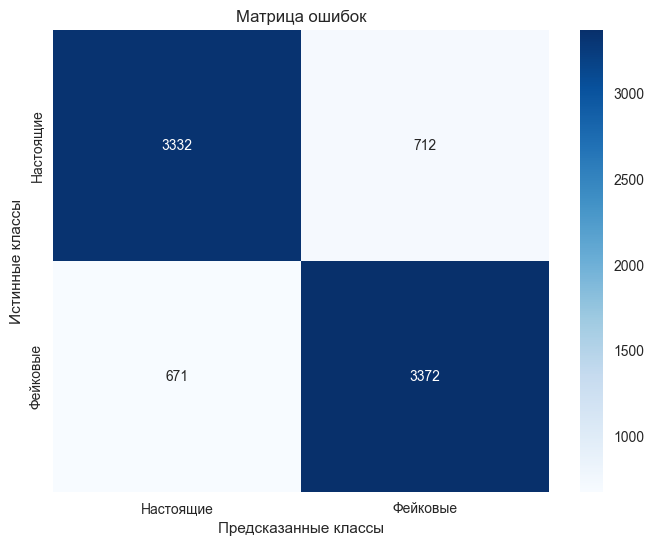

=== ИНТЕРПРЕТАЦИЯ МАТРИЦЫ ОШИБОК ===
True Negatives (TN): 3332 - правильно определили как настоящие
False Positives (FP): 712 - ошибочно определили как фейковые
False Negatives (FN): 671 - пропустили фейковые
True Positives (TP): 3372 - правильно определили как фейковые

Точность (Precision) = TP/(TP+FP) = 3372/4084 = 0.8257
Полнота (Recall) = TP/(TP+FN) = 3372/4043 = 0.8340


In [19]:
# Матрица ошибок (Confusion Matrix)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Настоящие', 'Фейковые'],
            yticklabels=['Настоящие', 'Фейковые'])
plt.title('Матрица ошибок')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')
plt.show()

print("=== ИНТЕРПРЕТАЦИЯ МАТРИЦЫ ОШИБОК ===")
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn} - правильно определили как настоящие")
print(f"False Positives (FP): {fp} - ошибочно определили как фейковые")
print(f"False Negatives (FN): {fn} - пропустили фейковые")
print(f"True Positives (TP): {tp} - правильно определили как фейковые")
print()
print(f"Точность (Precision) = TP/(TP+FP) = {tp}/{tp+fp} = {tp/(tp+fp):.4f}")
print(f"Полнота (Recall) = TP/(TP+FN) = {tp}/{tp+fn} = {tp/(tp+fn):.4f}")

## 8. Анализ важности признаков

**Преимущество логистической регрессии:** Мы можем понять, какие слова модель считает наиболее важными для классификации.

=== САМЫЕ ВАЖНЫЕ СЛОВА ДЛЯ ОПРЕДЕЛЕНИЯ ФЕЙКОВ (положительные коэффициенты) ===
having: 2.9686
making: 3.1375
soon: 3.1738
believe: 3.1932
coming: 3.2099
maybe: 3.2318
far: 3.2660
end: 3.4494
easily: 3.4945
isnt: 3.6208
quite: 3.6929
plus: 3.7266
wont: 3.7597
actually: 3.8418
instead: 3.9628

=== САМЫЕ ВАЖНЫЕ СЛОВА ДЛЯ ОПРЕДЕЛЕНИЯ НАСТОЯЩИХ ОТЗЫВОВ (отрицательные коэффициенты) ===
reason gave: -5.3832
admit: -5.0127
problem: -4.8581
bought friend: -4.8515
iti: -4.7364
wide: -4.5803
couple: -4.5431
replace: -4.5423
reason: -4.5106
downside: -4.3759
bought son: -4.3169
story told: -4.1040
plastic parts: -3.9641
lot fun: -3.8589
onei: -3.7663


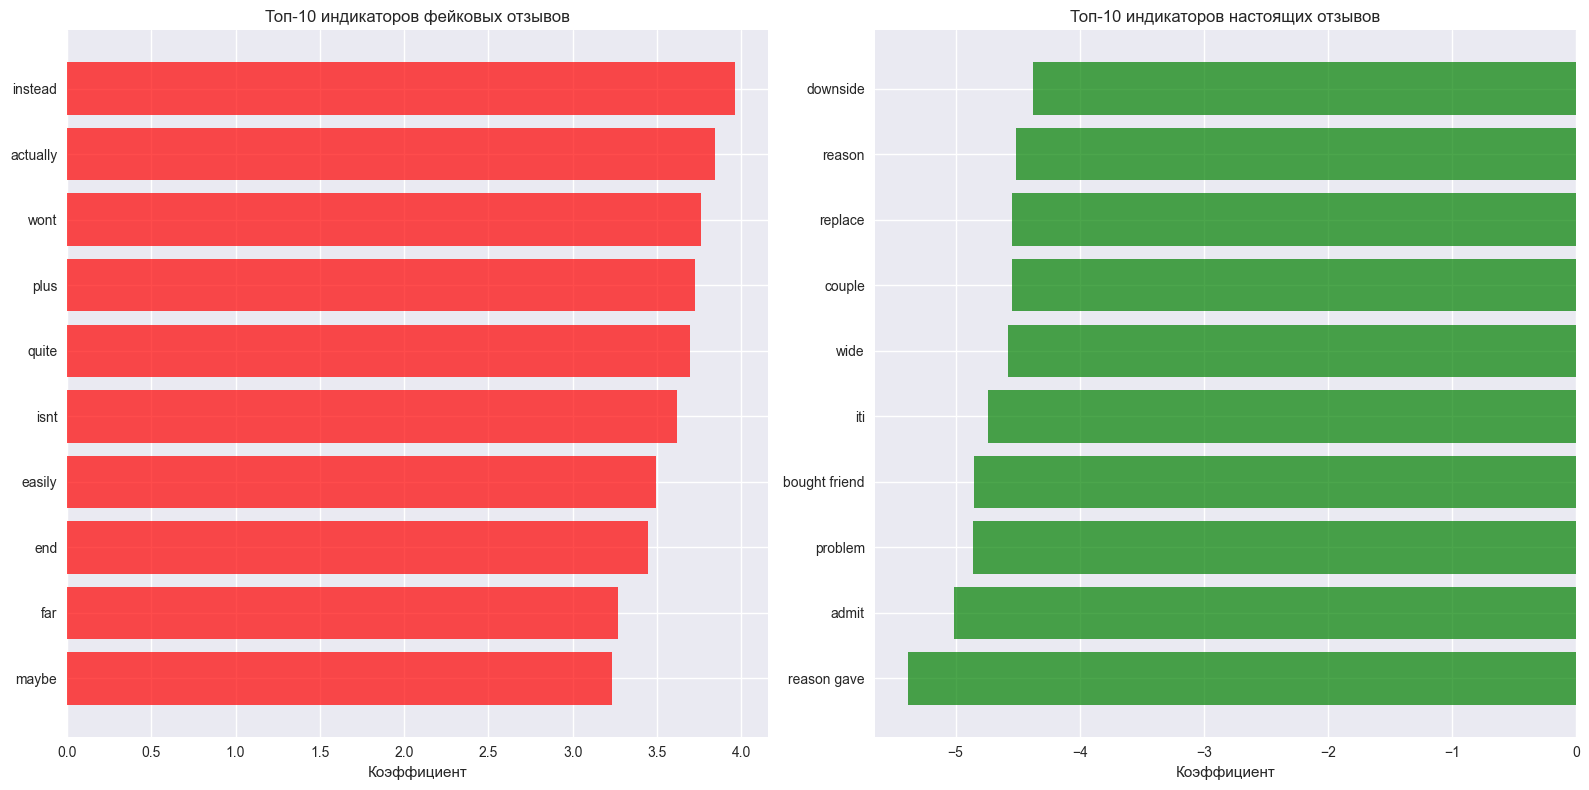

In [20]:
# Получаем коэффициенты модели
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

# Создаем DataFrame для анализа
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Сортируем по важности
feature_importance = feature_importance.sort_values('coefficient')

print("=== САМЫЕ ВАЖНЫЕ СЛОВА ДЛЯ ОПРЕДЕЛЕНИЯ ФЕЙКОВ (положительные коэффициенты) ===")
top_fake_indicators = feature_importance.tail(15)
for _, row in top_fake_indicators.iterrows():
    print(f"{row['feature']}: {row['coefficient']:.4f}")

print("\n=== САМЫЕ ВАЖНЫЕ СЛОВА ДЛЯ ОПРЕДЕЛЕНИЯ НАСТОЯЩИХ ОТЗЫВОВ (отрицательные коэффициенты) ===")
top_real_indicators = feature_importance.head(15)
for _, row in top_real_indicators.iterrows():
    print(f"{row['feature']}: {row['coefficient']:.4f}")

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Топ слова для фейков
top_fake = feature_importance.tail(10)
ax1.barh(range(len(top_fake)), top_fake['coefficient'], color='red', alpha=0.7)
ax1.set_yticks(range(len(top_fake)))
ax1.set_yticklabels(top_fake['feature'])
ax1.set_title('Топ-10 индикаторов фейковых отзывов')
ax1.set_xlabel('Коэффициент')

# Топ слова для настоящих отзывов
top_real = feature_importance.head(10)
ax2.barh(range(len(top_real)), top_real['coefficient'], color='green', alpha=0.7)
ax2.set_yticks(range(len(top_real)))
ax2.set_yticklabels(top_real['feature'])
ax2.set_title('Топ-10 индикаторов настоящих отзывов')
ax2.set_xlabel('Коэффициент')

plt.tight_layout()
plt.show()

## 9. Применение модели к новым отзывам

**Практическое применение:** Теперь мы можем использовать обученную модель для классификации новых отзывов.

In [21]:
def predict_review(text, model, vectorizer, threshold=0.5):
    """
    Функция для предсказания класса нового отзыва
    """
    # Очищаем текст
    cleaned = clean_text(text)
    
    # Векторизуем
    vectorized = vectorizer.transform([cleaned])
    
    # Получаем вероятность
    probability = model.predict_proba(vectorized)[0, 1]
    
    # Делаем предсказание
    prediction = 1 if probability > threshold else 0
    
    return {
        'prediction': prediction,
        'probability': probability,
        'confidence': max(probability, 1 - probability),
        'label': 'Фейковый' if prediction == 1 else 'Настоящий'
    }

# Тестируем на новых примерах
test_reviews = [
    "This product is absolutely amazing! Perfect quality! Five stars! Best purchase ever!",
    "The product is decent. It works as described, though the shipping took a bit longer than expected. Overall satisfied with the purchase.",
    "AMAZING! PERFECT! INCREDIBLE! BUY NOW! BEST EVER!",
    "Good value for the price. The build quality is solid and it serves its purpose well. Would recommend to others.",
    "Fantastic! Outstanding! Perfect! Amazing quality! Must buy!"
]

print("=== ТЕСТИРОВАНИЕ НА НОВЫХ ОТЗЫВАХ ===")
for i, review in enumerate(test_reviews, 1):
    result = predict_review(review, model, vectorizer)
    
    print(f"\n--- Отзыв {i} ---")
    print(f"Текст: '{review}'")
    print(f"Предсказание: {result['label']}")
    print(f"Вероятность фейка: {result['probability']:.4f} ({result['probability']*100:.2f}%)")
    print(f"Уверенность: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
    
    # Анализ ключевых слов
    cleaned = clean_text(review)
    vectorized = vectorizer.transform([cleaned])
    
    # Находим активные признаки
    active_features = vectorized.toarray()[0]
    feature_names = vectorizer.get_feature_names_out()
    
    active_words = [(feature_names[j], active_features[j], model.coef_[0][j]) 
                    for j in range(len(active_features)) if active_features[j] > 0]
    
    if active_words:
        # Сортируем по влиянию на решение
        active_words.sort(key=lambda x: abs(x[1] * x[2]), reverse=True)
        print("Ключевые слова:")
        for word, tfidf, coef in active_words[:5]:
            influence = tfidf * coef
            direction = "→ фейк" if influence > 0 else "→ настоящий"
            print(f"  '{word}': {influence:.4f} {direction}")

=== ТЕСТИРОВАНИЕ НА НОВЫХ ОТЗЫВАХ ===

--- Отзыв 1 ---
Текст: 'This product is absolutely amazing! Perfect quality! Five stars! Best purchase ever!'
Предсказание: Фейковый
Вероятность фейка: 0.8066 (80.66%)
Уверенность: 0.8066 (80.66%)
Ключевые слова:
  'stars': 0.6914 → фейк
  'absolutely': 0.6088 → фейк
  'quality': -0.4932 → настоящий
  'purchase': 0.2398 → фейк
  'perfect': 0.2357 → фейк

--- Отзыв 2 ---
Текст: 'The product is decent. It works as described, though the shipping took a bit longer than expected. Overall satisfied with the purchase.'
Предсказание: Фейковый
Вероятность фейка: 0.9309 (93.09%)
Уверенность: 0.9309 (93.09%)
Ключевые слова:
  'overall': 0.7318 → фейк
  'bit': -0.6694 → настоящий
  'longer': 0.6627 → фейк
  'decent': 0.4563 → фейк
  'took': 0.4025 → фейк

--- Отзыв 3 ---
Текст: 'AMAZING! PERFECT! INCREDIBLE! BUY NOW! BEST EVER!'
Предсказание: Фейковый
Вероятность фейка: 0.7870 (78.70%)
Уверенность: 0.7870 (78.70%)
Ключевые слова:
  'buy': 0.8218 → фейк
  'per

## 10. Выводы и следующие шаги

### Что мы изучили:

1. **Векторизация текста** - превращение слов в числа с помощью TF-IDF
2. **Логистическая регрессия** - простой но мощный алгоритм классификации
3. **Метрики оценки** - как измерить качество модели
4. **Интерпретируемость** - понимание того, как модель принимает решения

### Ограничения нашей модели:

- Простая обработка текста (можно улучшить лемматизацией)
- Только TF-IDF (можно попробовать эмбеддинги)
- Простая модель (можно попробовать более сложные алгоритмы)
- Маленький датасет (для реального применения нужно больше данных)

### Следующие шаги для улучшения:

1. **Больше данных** - увеличить размер датасета
2. **Лучшая обработка текста** - лемматизация, учет эмоций
3. **Продвинутые алгоритмы** - Random Forest, XGBoost, нейронные сети
4. **Кросс-валидация** - более надежная оценка модели
5. **Гиперпараметры** - подбор оптимальных параметров

### Для подкаста:

Этот пример отлично показывает основы ML:
- **Данные** → **Обработка** → **Признаки** → **Модель** → **Оценка** → **Применение**
- Важность понимания данных перед построением модели
- Разница между обучением и тестированием
- Интерпретируемость vs сложность модели

In [22]:
# Финальная демонстрация - интерактивный классификатор
print("=== ИНТЕРАКТИВНЫЙ КЛАССИФИКАТОР ГОТОВ К РАБОТЕ! ===")
print("\nВы можете использовать функцию predict_review() для классификации любых отзывов:")
print("\nПример:")
print("result = predict_review('Your review text here', model, vectorizer)")
print("print(result)")
print()
print("Модель обучена и готова к использованию! 🎉")
print()
print("📊 Финальная статистика:")
print(f"- Точность на тестовых данных: {accuracy:.2%}")
print(f"- Размер словаря: {len(feature_names)} слов/биграмм")
print(f"- Обучено на {X_train.shape[0]} отзывах")
print(f"- Протестировано на {X_test.shape[0]} отзывах")

=== ИНТЕРАКТИВНЫЙ КЛАССИФИКАТОР ГОТОВ К РАБОТЕ! ===

Вы можете использовать функцию predict_review() для классификации любых отзывов:

Пример:
result = predict_review('Your review text here', model, vectorizer)
print(result)

Модель обучена и готова к использованию! 🎉

📊 Финальная статистика:
- Точность на тестовых данных: 82.90%
- Размер словаря: 1000 слов/биграмм
- Обучено на 32345 отзывах
- Протестировано на 8087 отзывах


In [24]:
result = predict_review('Doubtful, but okay', model, vectorizer)
print(result)

{'prediction': 1, 'probability': 0.5675600503156908, 'confidence': 0.5675600503156908, 'label': 'Фейковый'}


In [31]:
result = predict_review('Doubtful, but okay', model, vectorizer)
print(result)

{'prediction': 1, 'probability': 0.5675600503156908, 'confidence': 0.5675600503156908, 'label': 'Фейковый'}
